In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.stats import powerlaw
import numpy as np
from math import log

In [2]:
"""
This is the state of the data from where we left off in 'distribution_analysis'

The analysis showed that clipping the distribution between 1 and 30 clicks allowed the best fit using the
powerlaw distribution.
"""
original_df = pd.read_csv('data/original/fm_interactions.csv', delimiter='\t')
interaction_df = original_df[original_df['interaction_type'].isin([1, 2, 3])]
user_group = interaction_df.groupby(['user_id'])
user_interaction_count = user_group['item_id'].count()
clipped_interactions = user_interaction_count.clip(1, 31)

In [3]:
"""
These are the three parameters of the powerlaw distribution that resulted in the best fit to the data
"""
a = 0.2
loc = .999999
scale = 30

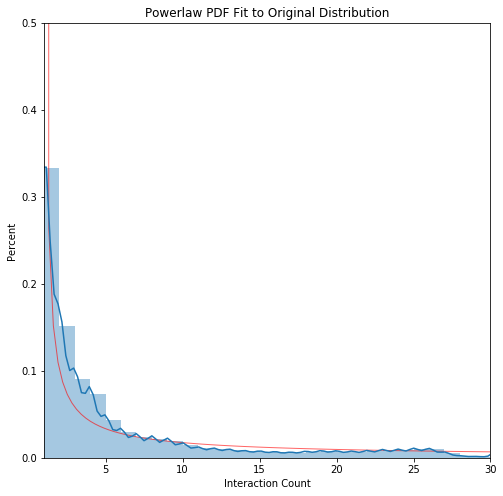

In [4]:
"""
For starters we'll plot the powerlaw probability distribution function in its original form...
"""
fig = plt.figure(figsize=(8, 8))
x = np.linspace(powerlaw.ppf(0.01, a, loc=loc, scale=scale),
                powerlaw.ppf(0.999, a, loc=loc, scale=scale), 100)
plt.plot(x, powerlaw.pdf(x, a, loc, scale),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
graph = sns.distplot(clipped_interactions, bins=30)
graph.set_title('Powerlaw PDF Fit to Original Distribution')
graph.set(xlabel='Interaction Count', ylabel='Percent', xlim=(1,30), ylim=(0, .5))
plt.show()

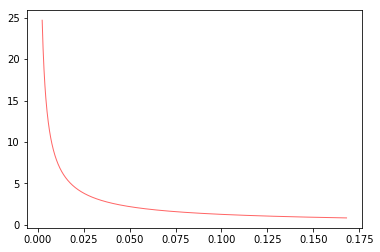

In [5]:
"""
Lets plot the simple untransformed powerlaw graph
"""
base_x = np.linspace(powerlaw.ppf(0.3, a),
                powerlaw.ppf(0.7, a), 1000)
plt.plot(base_x, powerlaw.pdf(base_x, a),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
plt.show()

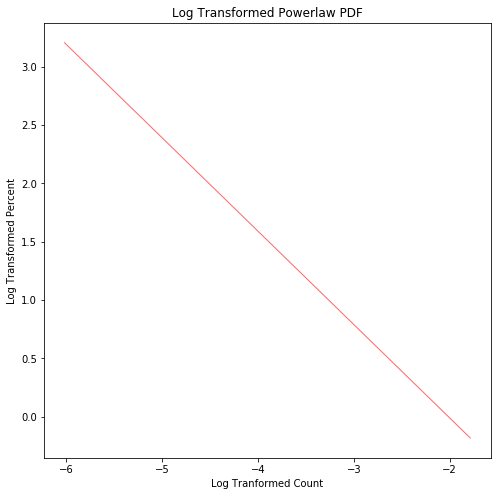

In [7]:
"""
Lets plot the log transformed simple untransformed powerlaw graph - we see that it gets transformed to linear space!
"""
fig = plt.figure(figsize=(8,8))
plt.plot(np.log(base_x), powerlaw.logpdf(base_x, a),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
plt.title('Log Transformed Powerlaw PDF')
plt.xlabel('Log Tranformed Count')
plt.ylabel('Log Transformed Percent')
plt.show()

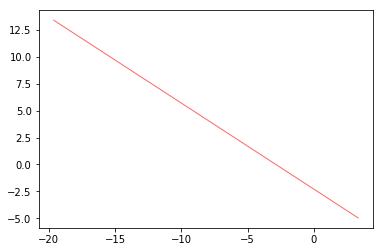

In [11]:
"""
Now lets ensure the loc and scale parameters transform to linear space as well.

Once we have the function transformed to linear space, we can also plot the line in 'y = mx + b' format and ensure
the lines are the same.
"""
trans_x = np.linspace(powerlaw.ppf(0.01, a, loc=loc, scale=scale),
                powerlaw.ppf(0.99, a, loc=loc, scale=scale), 1000)
plt.plot(np.log(trans_x - loc), powerlaw.logpdf(trans_x, a, loc=loc, scale=scale),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
plt.show()

In [12]:
"""
Now that we know how to plot the lines in a way that is linear, we can compute the equation of the line 'y = ax + b'

The original equation is y = a * ( (x - loc) / scale ) ^ (a - 1) ) / scale

We can tranform the equation to linear space by taking the log of both sides:

log(y) = (a - 1)log(x - loc) - (a - 1)log(scale) + log(a) - log(scale)

by transforming these variables as seen below, we get the equation:

y' = a'x' + b'

"""

x_prime = np.log(trans_x - loc)
a_prime = a - 1
b_prime = -(a - 1) * log(scale) + log(a) - log(scale)
y_prime = [a_prime * x + b_prime for x in x_prime]

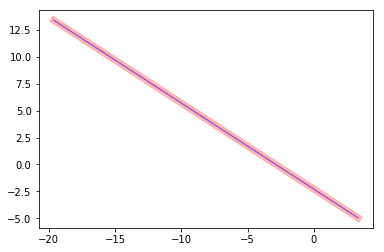

In [13]:
"""
Now we plot both the pdf line and the mx + b line to ensure that they are the same.
"""

plt.plot(x_prime, y_prime, 'r-', lw=7, alpha = .3, label='log transformed')
plt.plot(np.log(trans_x - loc), powerlaw.logpdf(trans_x , a, loc=loc, scale=scale),
       'b-', lw=1, alpha=0.6, label='powerlow pdf')
plt.show()

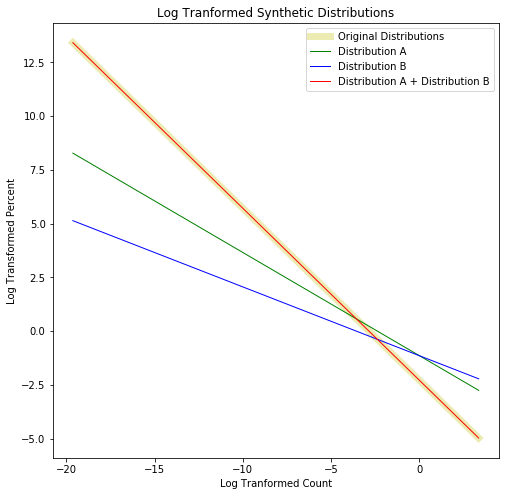

In [24]:
"""
Now we can plot two lines that sum up to our fitted line.  Since we know the equation of our line is:

y' = a'x' + b'

The equation of the two lines that sum to this line should be:

y'A = (1/2)(a'x' + b')
y'B = (1/2)(a'x' + b')

Thus y'A + y'B = y'

We can add 'delta' parameters to differentiate distributions A and B, such that:

y'A = (1/2)((a' + delta1) * x' + b' + delta2)
y'B = (1/2)((a' - delta1) * x' + b' - delta2)

once again,

y'A + y'B = y'
"""

delta1 = a_prime * .2
delta2 = 0 # b_prime * .1
y_prime_A = np.asarray([((a_prime + delta1) * x + b_prime + delta2) / 2 for x in x_prime])
y_prime_B = np.asarray([((a_prime - delta1) * x + b_prime - delta2) / 2 for x in x_prime])

fig = plt.figure(figsize=(8, 8))

plt.plot(x_prime, y_prime, 'y-', lw=7, alpha=0.3, label='Original Distributions')
plt.plot(x_prime, y_prime_A, 'g-', lw=1, label='Distribution A')
plt.plot(x_prime, y_prime_B, 'b-', lw=1, label='Distribution B')
plt.plot(x_prime, y_prime_B + y_prime_A, 'r-', lw=1, label='Distribution A + Distribution B')
plt.title('Log Tranformed Synthetic Distributions')
plt.xlabel('Log Tranformed Count')
plt.ylabel('Log Transformed Percent')
plt.legend()
plt.show()

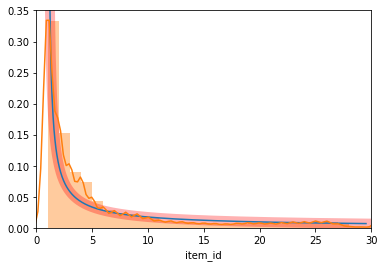

In [25]:
"""
Lets try and transform regular old y_prime back to its original distribution, so that we know we're getting it right
"""
trans_x = np.linspace(powerlaw.ppf(0.01, a, loc=loc, scale=scale),
                powerlaw.ppf(0.99, a, loc=loc, scale=scale), 1000)
plt.plot(trans_x, powerlaw.pdf(trans_x - loc, a, loc=0, scale=scale),
       'r-', lw=10, alpha=.3, label='powerlow pdf')
plt.plot(np.exp(x_prime) + loc, np.exp(y_prime))
sns.distplot(clipped_interactions, bins=30)
plt.xlim(0, 30)
plt.ylim(0, 0.35)
plt.show()

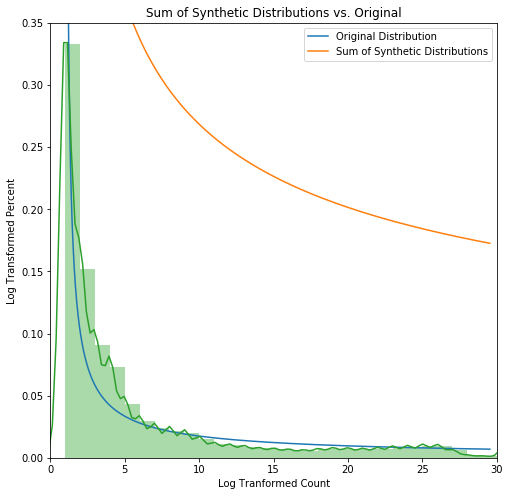

In [29]:
"""
We can now take these distributions and transform them from log space to regular space and plot their distributuion
again.  Uh-oh - it looks like C = A * B instead of what we intended - C = A + B.  Back to the drawing board...
"""

y_A = np.exp(y_prime_A)
y_B = np.exp(y_prime_B)

# plt.plot(np.exp(x_prime), y_A)
# plt.plot(np.exp(x_prime), y_B)

fig = plt.figure(figsize=(8,8))
plt.plot(np.exp(x_prime) + loc, np.exp(y_prime), label='Original Distribution')
plt.plot(np.exp(x_prime) + loc, y_A + y_B, label='Sum of Synthetic Distributions')
# plt.plot(np.exp(x_prime) + loc, y_B)
sns.distplot(clipped_interactions, bins=30)
plt.xlim(0, 30)
plt.ylim(0, 0.35)
plt.title('Sum of Synthetic Distributions vs. Original')
plt.xlabel('Log Tranformed Count')
plt.ylabel('Log Transformed Percent')
plt.legend()

plt.show()

